In [1]:
!pip install pymc3

Defaulting to user installation because normal site-packages is not writeable


### Imports:

In [3]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

Modelo

In [4]:
def SIR(y, t, p):
    dt = (1 - y[0])*p[0]*p[1]*(y[0])**p[2] + y[0]*p[0]*(1-p[1])*(1-y[0])**p[2]
    return [dt]

Testando os dados do modelo:

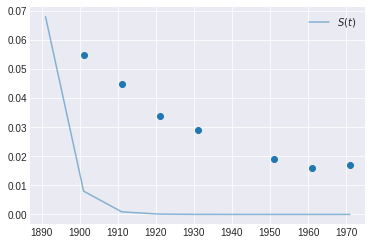

In [8]:
times = np.array([1891, 1901, 1911, 1921, 1931, 1951, 1961, 1971])


# Gerando curvas simuladas
y = odeint(SIR, y0=[0.068], t=times, args=((-0.22, 0.8, 1),), rtol=1e-8) # argumentos chutados
# dados (nesse caso ficticios)
yobs = np.array([[0.055], [0.045], [0.034], [0.029], [0.019], [0.016], [0.017]])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();

Definindo o modelo:

In [9]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.array([1901, 1911, 1921, 1931, 1951, 1961, 1971]),
    n_states=1,
    n_theta=3,
    t0=1891,
)

Estimação dos parametro (c, s e a):

In [31]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)

    # Distribuições a priori (lower liminf, upper limsup)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    c = pm.Uniform('c', -2, 0)
    s = pm.Uniform('s', 0, 1)
    a = pm.Uniform('a', 0, 40)
    
    sir_curves = sir_model(y0=[0.068], theta=[c, s, a])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)
#    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(3000, tune=1500, start={'R0': np.array(2), 'c': np.array(-0.2), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(4)})

/tmp/ipykernel_3798/1112468467.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(3000, tune=1500, start={'R0': np.array(2), 'c': np.array(-0.2), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(4)})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, s, c, R0, sigma]


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1896462517369D+04   r2 =                  NaN


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1896580824838D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1970226992800D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1966350200270D+04   r2 =                  NaN


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1969060666982D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1954581203673D+04   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1968448904335D+04   r2 =  0.9206460911993D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1968448904335D+04   r2 =  0.9206460911993D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue

/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1929158487445D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1914679425237D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1919178263998D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1963942029915D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1910777334330D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1966817078923D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1966338512192D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1896551621330D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1966370753297D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1934163609417D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1907333414547D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1902518736019D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1900793306646D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1903498266265D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1904896047986D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1945457484467D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1916942624460D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1935178724947D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1909985404836D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1915748696167D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1931162785448D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1910390999712D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1916915471173D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1925721818239D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1917508462839D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1927103130127D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1921780473498D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1930427471598D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1915207813800D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1921692518025D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1910484189279D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1948335201696D+04   r2 =                  NaN


Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 6251 seconds.
There were 503 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6283950893842133, but should be close to 0.8. Try to increase the number of tuning steps.
There were 872 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4611058919649082, but should be close to 0.8. Try to increase the number of tuning steps.
There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
There were 469 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6208563945956586, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during

Dados da estimação dos parametros:

In [32]:
data = az.from_pymc3(trace=trace)
data

Got error No model on context stack. trying to find log_likelihood in translation.
/home/wellington/.local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Posteriori dos parametros

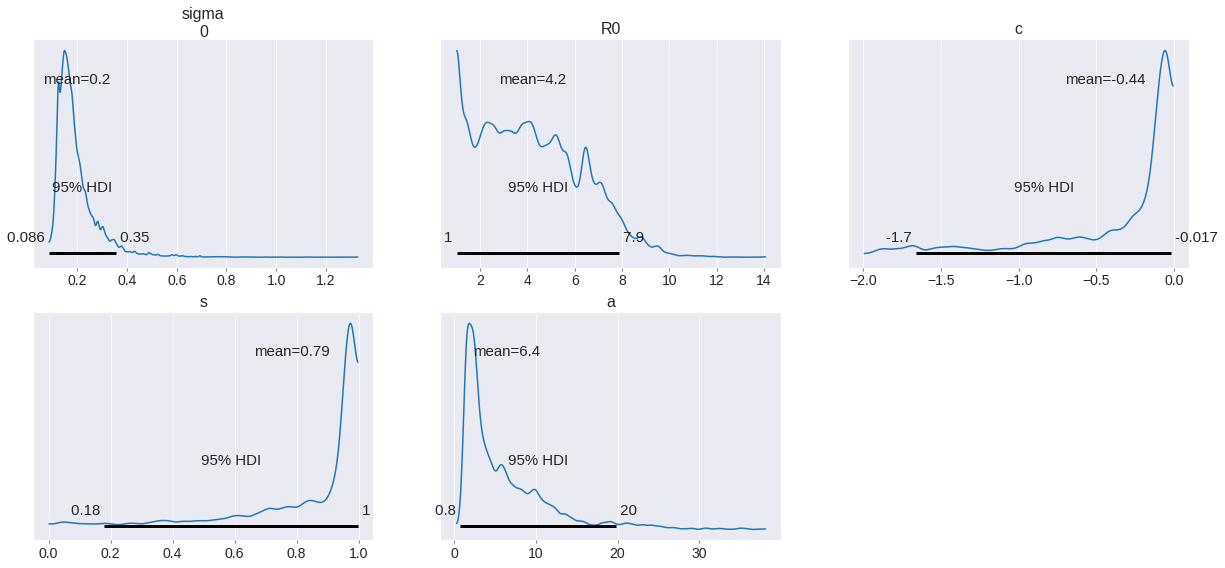

In [63]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);
plt.savefig("output_image.png")

Modelagem do Gaelic

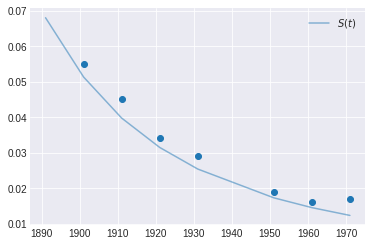

In [59]:
y = odeint(SIR, y0=[0.068], t=times, args=((-0.11, 0.96, 1.5),), rtol=1e-8) # argumentos chutados

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();